In [1]:
import pandas as pd 
import os 
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cu126
CUDA available: True
Device: GPU


In [2]:
class Config:
    DATA_PATH = "/kaggle/input/food-ingredients-and-recipe-dataset-with-images/Food Ingredients and Recipe Dataset with Image Name Mapping.csv"
    IMG_DIR = "/kaggle/input/food-ingredients-and-recipe-dataset-with-images/Food Images/Food Images"

    EMBED_SIZE = 256
    NUM_HEADS = 4
    NUM_LAYERS = 2
    MAX_SEQ_LENGTH = 512

    BATCH_SIZE = 32
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 15
    WEIGHT_DECAY = 0.01

    FREQ_THRESHOLD = 2
    TRAIN_SPLIT = 0.8
    RANDOM_SEED = 42

    IMG_SIZE = 128
    IMG_RESIZE = 132


    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Configuration loaded")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Embedding size: {Config.EMBED_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f" Device: {Config.DEVICE}")

Configuration loaded
Batch size: 32
Embedding size: 256
Epochs: 15
 Device: cuda


In [3]:
def load_and_clean_data(data_path):
    print("Loading data....")
    df = pd.read_csv(data_path)
    df = df.dropna(subset=['Instructions', 'Image_Name'])
    df = df[~df['Image_Name'].str.contains('#NAME', na = False)]
    df = df.reset_index(drop=True)

    print(f"✓ Loaded {len(df)} recipes")
    return df

def clean_text(text):
    text =str(text).lower()
    text = re.sub(r"\[|\]|\'", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text

    
def prepare_data_split(df, test_size=0.2, random_state=42):

    df['cleaned_instructions'] = df['Instructions'].apply(clean_text)

    
    train_df, val_df = train_test_split(
        df,test_size=test_size, random_state=random_state
    )
    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    return train_df,val_df

df = load_and_clean_data(Config.DATA_PATH)
train_df, val_df = prepare_data_split(df, test_size = 1 - Config.TRAIN_SPLIT)

Loading data....
✓ Loaded 13463 recipes
Training samples: 10770
Validation samples: 2693


In [4]:
class Vocabulary:
    def __init__(self,freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>":0, "<START>":1, "<END>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold
    def build_vocabulary(self,sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in sentence.split():
                frequencies[word] +=1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx +=1


    def numericalize(self, text):
        tokenized_text = text.split()
        return[
            self.stoi.get(token,self.stoi["<UNK>"])
            for token in tokenized_text
        ]

print("Building vocabulary")
vocab = Vocabulary(freq_threshold=Config.FREQ_THRESHOLD)
vocab.build_vocabulary(train_df['cleaned_instructions'].tolist())
vocab_size = len(vocab.stoi)

print(f"Vocabulary size: {vocab_size} words")

Building vocabulary
Vocabulary size: 8215 words


In [5]:
class FoodDataset(Dataset):
    def __init__(self, df, img_dir, vocab, transform=None, max_len=512):
        self.df = df
        self.img_dir = img_dir
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        image_id = self.df.iloc[index]['Image_Name']
        jpg_path = os.path.join(self.img_dir, f'{image_id}.jpg')
        png_path = os.path.join(self.img_dir, f'{image_id}.png')
    
        if os.path.exists(jpg_path):
            image = Image.open(jpg_path).convert("RGB")
        elif os.path.exists(png_path):
            image = Image.open(png_path).convert("RGB")
        else:
            raise FileNotFoundError(f"Image not found: {image_id}")

        
        if self.transform:
            image = self.transform(image)
        
        caption = self.df.iloc[index]['cleaned_instructions']
        recipe_seq = [self.vocab.stoi['<START>']]
        recipe_seq += self.vocab.numericalize(caption)
        recipe_seq.append(self.vocab.stoi['<END>'])

        if len(recipe_seq) > self.max_len:
            recipe_seq = recipe_seq[:self.max_len-1] + [self.vocab.stoi['<END>']]
        
        return image, torch.tensor(recipe_seq)

In [6]:
class CollateFunction:
    def __init__(self,pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = torch.stack([item[0] for item in batch], dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_RESIZE, Config.IMG_RESIZE)),
    transforms.RandomCrop((Config.IMG_RESIZE, Config.IMG_RESIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_RESIZE, Config.IMG_RESIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = FoodDataset(train_df, Config.IMG_DIR, vocab, transform=train_transform)
val_dataset = FoodDataset(val_df, Config.IMG_DIR, vocab, transform= val_transform)

pad_idx = vocab.stoi["<PAD>"]
collate_fn = CollateFunction(pad_idx=pad_idx)

train_loader = DataLoader(
    train_dataset, batch_size = Config.BATCH_SIZE,
    shuffle = True,
    collate_fn = collate_fn,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size = Config.BATCH_SIZE,
    shuffle = False,
    collate_fn = collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 337
Val batches: 85


In [8]:
#checking the data preprocessing pipeline
dataiter = iter(train_loader)
images, recipes = next(dataiter)

print(f"Batch of Image shape: {images.shape}")
print(f"Batch of Recipes shape: {recipes.shape}")

Batch of Image shape: torch.Size([32, 3, 132, 132])
Batch of Recipes shape: torch.Size([32, 363])


In [9]:
class CNN_Encoder(nn.Module):
    def __init__(self, embed_size, unfreeze_layers = 1):
        super(CNN_Encoder, self).__init__()

        resnet = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

        for param in resnet.parameters():
            param.requires_grad = False

        layers = list(resnet.children())
        for layer in layers[-unfreeze_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.resnet = nn.Sequential(*layers[:-1])

        self.linear = nn.Linear(512, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.relu = nn.ReLU()

    def forward(self, images):
        features = self.resnet(images)

        features = features.reshape(features.size(0),-1)

        features = self.relu(self.bn(self.linear(features)))
        return features

In [10]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, nhead, num_layers, max_seq_length):
        super(TransformerDecoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(max_seq_length, embed_size))
        self.max_seq_length = max_seq_length
        
        self.feature_projection = nn.Linear(embed_size, embed_size * 8)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, 
            nhead=nhead, 
            dim_feedforward=embed_size * 2,
            batch_first=True,
            dropout = 0.1
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, features, captions):
        batch_size, seq_len = captions.shape
        
        embeddings = self.embedding(captions)
        embeddings = embeddings + self.positional_encoding[:seq_len, :].unsqueeze(0)
        embeddings = self.dropout(embeddings)
        
        projected = self.feature_projection(features)
        memory = projected.view(batch_size, 8, -1)  
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len)
        tgt_mask = tgt_mask.to(captions.device)
        output = self.transformer_decoder(tgt=embeddings, memory=memory, tgt_mask=tgt_mask)
        
        return self.fc_out(output)

In [11]:
class InverseCookingModel(nn.Module):
    def __init__(self, embed_size, vocab_size, nhead, num_layers, max_seq_length):
        super(InverseCookingModel, self).__init__()
        self.encoder = CNN_Encoder(embed_size)
        self.decoder = TransformerDecoder(vocab_size, embed_size, nhead, num_layers, max_seq_length)

    def forward(self, images, captions):
        features =self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [12]:
print(f"Initializing model on {Config.DEVICE}...")
model = InverseCookingModel(
    embed_size = Config.EMBED_SIZE,
    vocab_size = vocab_size,
    nhead = Config.NUM_HEADS,
    num_layers = Config.NUM_LAYERS,
    max_seq_length = Config.MAX_SEQ_LENGTH
).to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully")
print(f"Total parameters: {total_params:,}")

with torch.no_grad():
    test_features = model.encoder(images.to(Config.DEVICE))
    print(f"Model test: ")
    print(f"Input images: {images.shape}")
    print(f"Extracted features; {test_features.shape}")

Initializing model on cuda...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 61.8MB/s]


Model initialized successfully
Total parameters: 17,761,623
Model test: 
Input images: torch.Size([32, 3, 132, 132])
Extracted features; torch.Size([32, 256])


In [13]:
def train_model(model, train_loader, criterion, optimizer, device, vocab_size):
    model.train()
    total_loss = 0

    for batch_idx, (images, captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        targets = captions[:, 1:]
        dec_input = captions[:, :-1]
                
        outputs = model(images, dec_input)
        loss = criterion(outputs.reshape(-1, vocab_size),targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f"Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        avg_loss = total_loss/len(train_loader)

    return avg_loss

def validate(model, val_loader, criterion, device, vocab_size):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            captions = captions.to(device)

            targets = captions[:, 1:]
            dec_input = captions[:, :-1]

            outputs = model(images, dec_input)
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            total_loss += loss.item()

    avg_loss = total_loss/len(val_loader)
    return avg_loss


print("Training function defined")

Training function defined


In [14]:
criterion = nn.CrossEntropyLoss(ignore_index = vocab.stoi["<PAD>"])
optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Training Started")
print(f"Device: {Config.DEVICE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Learning rate: {Config.LEARNING_RATE}")

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(Config.NUM_EPOCHS):
    print(f"Epoch [{epoch +1}/{Config.NUM_EPOCHS}]")


train_loss = train_model(model, train_loader, criterion, optimizer, Config.DEVICE, vocab_size)
history['train_loss'].append(train_loss)

val_loss = validate(model, val_loader, criterion, Config.DEVICE, vocab_size)
history['val_loss'].append(val_loss)

schedular.step(val_loss)
current_lr = optimizer.param_groups[0]['lr']


print(f"Epoch {epoch+1} Summary:")
print(f"Train loss: {train_loss:.4f}")
print(f"Val loss: {val_loss:.4f}")
print(f"Learning Rate: {current_lr:.6f}")

if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save({
        'epoch' : epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'vocab_size': vocab_size,
        'config':{
            'embed_size': Config.EMBED_SIZE,
            'num_head': Config.NUM_HEADS,
            'num_layers': Config.NUM_LAYERS,
            'max_seq_length': Config.MAX_SEQ_LENGTH
        }
    }, "best_inverse_cooking_model.pth")
    print(f"Best model saved!(val loss: {best_val_loss:.4f})")

print("Training Complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Training Started
Device: cuda
Epochs: 15
Batch size: 32
Learning rate: 0.0003
Epoch [1/15]
Epoch [2/15]
Epoch [3/15]
Epoch [4/15]
Epoch [5/15]
Epoch [6/15]
Epoch [7/15]
Epoch [8/15]
Epoch [9/15]
Epoch [10/15]
Epoch [11/15]
Epoch [12/15]
Epoch [13/15]
Epoch [14/15]
Epoch [15/15]
Batch [0/337], Loss: 9.1766
Batch [50/337], Loss: 6.1947
Batch [100/337], Loss: 5.5646
Batch [150/337], Loss: 5.1504
Batch [200/337], Loss: 4.6572
Batch [250/337], Loss: 4.7076
Batch [300/337], Loss: 4.5868
Epoch 15 Summary:
Train loss: 5.3340
Val loss: 4.4065
Learning Rate: 0.000300
Best model saved!(val loss: 4.4065)
Training Complete!
Best validation loss: 4.4065


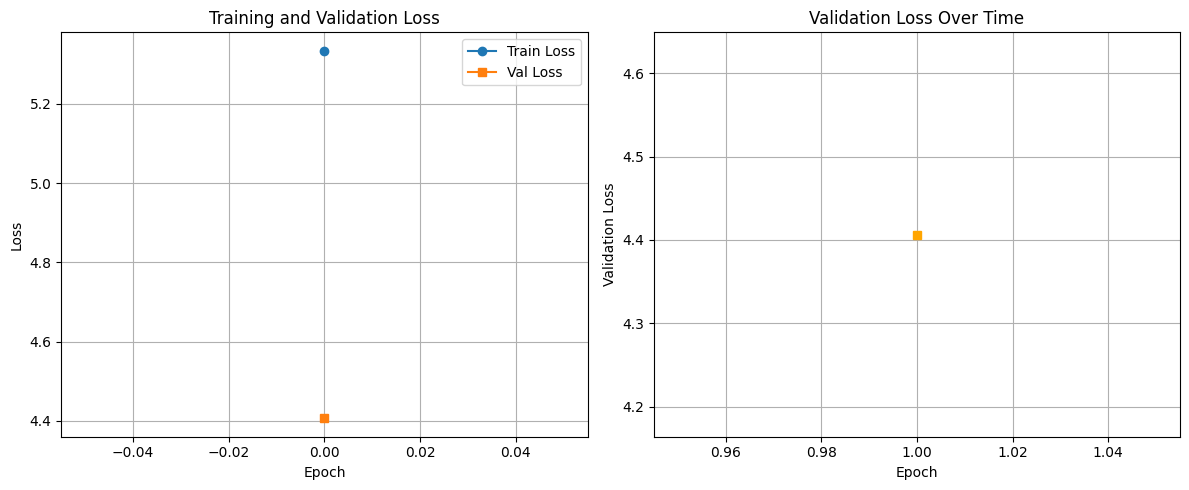


✓ Training plot saved as 'training_history.png'
Final train loss: 5.3340
Final val loss: 4.4065
Best val loss: 4.4065 (Epoch 1)


In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
epochs = list(range(1, len(history['train_loss']) + 1))
plt.plot(epochs, history['val_loss'], marker='s', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training plot saved as 'training_history.png'")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")
print(f"Best val loss: {min(history['val_loss']):.4f} (Epoch {history['val_loss'].index(min(history['val_loss'])) + 1})")


In [16]:
def generate_recipe(image_path, model, vocab,transform, device, max_len=200, temperature=0.8, top_k=50):
    model.eval()
    with torch.no_grad():
        img = Image.open(image_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        
        features = model.encoder(img)
        recipe_ids = [vocab.stoi["<START>"]]
        
        for _ in range(max_len):
            captions = torch.tensor([recipe_ids]).to(device)
            outputs = model.decoder(features, captions)
            
            
            logits = outputs[0, -1, :] / temperature
            
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')
            
            probs = torch.softmax(logits, dim=-1)
            predicted_id = torch.multinomial(probs, 1).item()
            
            recipe_ids.append(predicted_id)
            
            if predicted_id == vocab.stoi["<END>"]:
                break
        words = [vocab.itos[i] for i in recipe_ids]

        words = [w for w in words if w not in ['<START>','<END>','<PAD>']]
        recipe = ' '.join(words)
        
        return recipe

In [17]:
checkpoint = torch.load("best_inverse_cooking_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (val loss: {checkpoint['val_loss']:.4f})")

num_samples = 5

for i in range(num_samples):
    sample = val_df.iloc[i]
    image_name = sample["Image_Name"]

    jpg_path = os.path.join(Config.IMG_DIR, f'{image_name}.jpg')
    png_path = os.path.join(Config.IMG_DIR, f'{image_name}.png')
    image_path = jpg_path if os.path.exists(jpg_path) else png_path

    generated_recipe = generate_recipe(
        image_path, model, vocab, val_transform, Config.DEVICE, temperature=0.7, top_k=50
    )

    print(f"Image: {image_name}")
    print(f"Original: {sample['Instructions'][:200]}....")
    print(f"Generated: {generated_recipe[:200]}....")

Loaded best model (val loss: 4.4065)
Image: smoked-salmon-fennel-and-goat-cheese-toasts-102632
Original: Preheat oven to 350°F. Mix first 5 ingredients in small bowl to blend. Set aside.
Brush oil over both sides of bread. Arrange bread in single layer on large baking sheet. Bake until bread is just cris....
Generated: preheat oven to 425f or medium bowl of parchment paper with 1 hour cut each each addition in middle position rack in large bowl of oven to 425f place in center of oven to prepared pan with remaining i....
Image: spicy-thai-tofu-with-red-bell-peppers-and-peanuts-242489
Original: Heat oil in wok over high heat. Add bell peppers, ginger, and garlic; sauté until peppers just begin to soften, about 2 minutes. Add tofu and green onions; toss 2 minutes. Add next 3 ingredients. Toss....
Generated: preheat oven to 350f coat a large skillet over low until smooth and chill butter about 8 minutes add sugar and stir to 1 cup sugar and 1 cup cream and vanilla and chill until golden br

In [18]:
with open("vocab.pkl","wb") as f:
    pickle.dump(vocab, f)

print("Vocabulary saved to vocab.pkl")

print("Model saved as best_inverse_cooking_model.pth")

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'vocab_size': vocab_size,
    'config': {
        'embed_size': Config.EMBED_SIZE,
        'num_heads': Config.NUM_HEADS,
        'num_layers': Config.NUM_LAYERS,
        'max_seq_length': Config.MAX_SEQ_LENGTH,
        'img_size': Config.IMG_SIZE
    },
    'val_loss': best_val_loss
}, "inverse_cooking_complete.pth")
print("Complete package saved as 'inverse_cooking_complete.pth'")

Vocabulary saved to vocab.pkl
Model saved as best_inverse_cooking_model.pth
Complete package saved as 'inverse_cooking_complete.pth'
